In [1]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = "2,3"
sys.path.append('/home/naxos2-raid25/ojeda040/local/styvesg/code/nsd_gnet8x/')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

/tmp/ipykernel_13544/3759773396.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Alexnet-based encoding model of brain activity

In [2]:
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict, zip_dict
from src.load_nsd import ordering_split
from config import *
import torch
import matplotlib.pyplot as plt
from nsd_access import NSDAccess
from PIL import Image


# First URL: This is the original read-only NSD file path (The actual data)
# Second URL: Local files that we are adding to the dataset and need to access as part of the data
# Object for the NSDAccess package
nsda = NSDAccess('/home/naxos2-raid25/kneel027/home/surly/raid4/kendrick-data/nsd', '/home/naxos2-raid25/kneel027/home/kneel027/nsd_local')

In [3]:
import torch
use_device = "cuda:1"
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device(use_device) #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 2
device#: 0
device name: NVIDIA A100-PCIE-40GB

torch: 1.12.1.post201
cuda:  11.2
cudnn: 8401
dtype: torch.float32


# File locations

In [4]:
input_dir = root_dir + "output/multisubject/"
model_dir = input_dir + 'anet_fwrf_nsdgeneral_Feb-02-2022_1002/' 

stim_dir = root_dir+'../../data/nsd/stims/'
voxel_dir = root_dir+'../../data/nsd/voxels/'

exp_design_file = root_dir+"../../data/nsd/nsd_expdesign.mat"
#exp_design_file = root_dir+"../../data/nsd/nsdsynthetic_expdesign.mat"

output_dir = model_dir

# Reload model files

In [5]:
checkpoint = torch.load(model_dir + 'model_params')
#print(checkpoint)
print (checkpoint.keys())
model_params = checkpoint['best_params']
subjects = list(checkpoint['subjects'])
print(subjects)

dict_keys(['subjects', 'sample_batch_size', 'voxel_batch_size', 'holdout_frac', 'lmask', 'fmask', 'tuning_masks', 'best_params', 'val_cc', 'brain_nii_shape', 'voxel_index', 'voxel_roi', 'voxel_mask'])
[1, 2, 3, 4, 5, 6, 7, 8]


In [6]:
print ([p.shape for p in checkpoint['best_params'][3]])

[(11356, 3), (11356, 2688), (11356,), (11356, 2688), (11356, 2688)]


# Load stimuli

In [8]:
from utils import *

# ONE SUBJECTS 

# ----------- Load data ------------
x_train, x_val, _, _, _, _, _, _, _, _, val_trails, _ = load_nsd(vector = "c_img_0", loader = False, average = True, return_trial = True)
#x_train, x_val, _, _, _, _, _, _, _, _, train_trails, val_trails, _ = load_nsd(vector = "c_img_0", loader = False, return_trial = True)

val_voxel_data    = {}
val_stim_ordering = {}
val_voxel_data[1] = x_val.numpy()
val_stim_ordering[1] = val_trails
print(max(val_trails))


# 9000 samples in validation and training set. 
# ----------- Load Stimuli ------------
subj1_train = nsda.stim_descriptions[(nsda.stim_descriptions['subject1'] != 0) & (nsda.stim_descriptions['shared1000'] == False)]
print(subj1_train)
image_data = {}
data = []
w, h = 227, 227  # resize to integer multiple of 64
for i in tqdm(range(9000), desc="loading in images"):
    
    nsdId = subj1_train.iloc[i]['nsdId']
    ground_truth_np_array = nsda.read_images([nsdId], show=False)
    ground_truth = Image.fromarray(ground_truth_np_array[0])
    
    imagePil = ground_truth.resize((w, h), resample=Image.Resampling.LANCZOS)
    image = np.array(imagePil).astype(np.float32) / 255.0
    
    # testing = Image.fromarray((image * 255).astype(np.uint8))
    # testing.save("test.png")
    data.append(image)
    
    
image_data[1] = np.moveaxis(np.array(data), 3, 1)
print(image_data.keys())
print ('block size:', image_data[1].shape, ', dtype:', image_data[1].dtype, ', value range:',\
           np.min(image_data[1]), np.max(image_data[1]))


# MULTIPLE SUBJECTS
# print(exp_design_file)
# exp_design = loadmat(exp_design_file)
# print(exp_design)
# ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)
# print(ordering)

# from src.load_nsd import image_feature_fn

# image_data = {}
# for s in subjects: 
#     image_data_set = h5py.File(stim_dir + "S%d_stimuli_227.h5py"%s, 'r')
#     image_data[s] = image_feature_fn(np.copy(image_data_set['stimuli']))
#     image_data_set.close()
#     print ('--------  subject %d  -------' % s)
#     print ('block size:', image_data[s].shape, ', dtype:', image_data[s].dtype, ', value range:',\
#            np.min(image_data[s]), np.max(image_data[s]))
    
#     break

loading validation samples: 100%|██████████| 1500/1500 [00:00<00:00, 2538.84it/s]


shapes:  torch.Size([7386, 11838]) torch.Size([1473, 11838]) torch.Size([197, 11838]) torch.Size([196, 11838]) torch.Size([591, 11838]) torch.Size([7386, 768]) torch.Size([1473, 768]) torch.Size([197, 768]) torch.Size([196, 768]) torch.Size([591, 768])
8999
       cocoId  cocoSplit                         cropBox      loss  nsdId  \
13      24610    val2017            (0, 0, 0.125, 0.125)  0.125000     13   
27     254016    val2017                 (0, 0.25, 0, 0)  0.000000     27   
71     286908    val2017                (0, 0, 0.0, 0.0)  0.000000     71   
85     516318    val2017  (0, 0, 0.16640625, 0.16640625)  0.000000     85   
88     464251    val2017    (0, 0, 0.1421875, 0.1421875)  0.000000     88   
...       ...        ...                             ...       ...    ...   
72981  255849  train2017               (0, 0, 0.0, 0.25)  0.000000  72981   
72983  348478  train2017    (0, 0, 0.1671875, 0.1671875)  0.000000  72983   
72985  348480  train2017  (0, 0, 0.16640625, 0.16

loading in images: 100%|██████████| 9000/9000 [00:35<00:00, 253.93it/s]


dict_keys([1])
block size: (9000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0


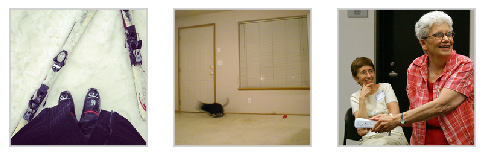

In [9]:
# MULTIPLE SUBJECTS
# n = 1000
# plt.figure(figsize=(6,2*len(subjects)))
# print(subjects)
# for k,s in enumerate(subjects): 
#     print(k)
#     print(s)
#     for i in range(3):
#         plt.subplot(len(subjects), 3, 3*k+i+1)
#         plt.imshow(image_data[0][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
#         plt.gca().get_xaxis().set_visible(False)
#         plt.gca().get_yaxis().set_visible(False)

# ONE SUBJECTS  
n = 1000
plt.figure(figsize=(6,2*8))
for i in range(3):
    plt.subplot(1, 3, 3*0+i+1)
    plt.imshow(image_data[1][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

## Voxel masks

In [10]:
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]

brain_nii_shape = checkpoint['brain_nii_shape']
print(brain_nii_shape)
nsdcore_val_cc  = checkpoint['val_cc']
print(nsdcore_val_cc)
voxel_mask      = checkpoint['voxel_mask']
print(voxel_mask)
voxel_idx       = checkpoint['voxel_index']
print(voxel_idx)
voxel_roi       = checkpoint['voxel_roi']
print(voxel_roi)

{1: (81, 104, 83), 2: (82, 106, 84), 3: (81, 106, 82), 4: (85, 99, 80), 5: (79, 97, 78), 6: (85, 113, 83), 7: (78, 95, 81), 8: (80, 103, 78)}
{1: array([0.2795512 , 0.64249223, 0.3834666 , ..., 0.67321074, 0.07908878,
       0.08921698], dtype=float32), 2: array([0.02590741, 0.4880561 , 0.55287683, ..., 0.17925675, 0.17671865,
       0.23876166], dtype=float32), 3: array([0.07717124, 0.5066075 , 0.51811725, ..., 0.5291956 , 0.4569164 ,
       0.10912606], dtype=float32), 4: array([0.409394  , 0.376009  , 0.5146729 , ..., 0.27218953, 0.21275707,
       0.05832073], dtype=float32), 5: array([0.21948051, 0.45039895, 0.47325143, ..., 0.37581238, 0.6320198 ,
       0.55694956], dtype=float32), 6: array([0.32680348, 0.4599477 , 0.42416978, ..., 0.20125589, 0.15386221,
       0.03002027], dtype=float32), 7: array([0.16438697, 0.29408678, 0.4034662 , ..., 0.2250655 , 0.22513315,
       0.22610769], dtype=float32), 8: array([-0.01727365,  0.07816915,  0.07074112, ...,  0.44722778,
        0.331

---
# Load NSD Data
## Load NSD voxel data

In [13]:
prep_path = "/export/raid1/home/kneel027/nsd_local/preprocessed_data/"
latent_path = "/export/raid1/home/kneel027/Second-Sight/latent_vectors/"

brain_data = torch.load(prep_path + "x/whole_region_11838_all.pt").requires_grad_(False)
print(brain_data.shape)
voxel_data = {}
voxel_data[1] = brain_data.numpy()
print(voxel_data.keys())
print(type(voxel_data[1]))
print(voxel_data[1].shape)


tensor([[ 0.1830, -0.3697, -0.2224,  ..., -0.7150, -0.2655, -1.1130],
        [ 0.0812,  1.1509, -0.2881,  ..., -0.5480, -0.2593, -0.2947],
        [ 0.8498,  1.1559, -0.2821,  ...,  0.3260, -0.3417, -0.5025],
        ...,
        [-0.8972, -1.2062,  0.9798,  ..., -1.8790,  0.4738, -0.9788],
        [-0.2667, -0.0417, -0.2821,  ..., -0.4437,  1.0471,  0.4114],
        [-1.2337,  1.3390,  1.2274,  ...,  1.1919,  1.6166, -0.0520]])
torch.Size([30000, 11838])
dict_keys([1])
<class 'numpy.ndarray'>
(30000, 11838)


In [85]:
#voxel_data_set = h5py.File(root_dir+'voxel_synth_data_V1-4_part1.h5py', 'r')
voxel_data_set = h5py.File(voxel_dir+'voxel_data_nsdgeneral_part1.h5py', 'r')
#voxel_data_set = h5py.File(voxel_dir+'voxel_data_V1_4_part1.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()
voxel_data = voxel_data_dict['voxel_data']


#voxel_data_set = h5py.File(root_dir+'voxel_synth_data_V1-4_part2.h5py', 'r')
voxel_data_set = h5py.File(voxel_dir+'voxel_data_nsdgeneral_part2.h5py', 'r')
#voxel_data_set = h5py.File(voxel_dir+'voxel_data_V1_4_part2.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()
voxel_data.update(voxel_data_dict['voxel_data'])

voxel_data = {int(s): voxel_data[s] for s in voxel_data.keys()}
print(voxel_data.keys)
print(voxel_data[1].shape)
print(type(voxel_data[1]))

<built-in method keys of dict object at 0x7f0513eb4540>
(30000, 11838)
<class 'numpy.ndarray'>


# Ordering

In [91]:
def ordering_split(voxel, ordering, combine_trial=False):
    data_size, nv = voxel.shape 
    print ("Total number of voxels = %d" % nv)
    print(data_size)
    ordering_data = ordering[:data_size]
    print(ordering_data)
    shared_mask = ordering_data<1000  # the first 1000 indices are the shared indices
    print(shared_mask)
    
    if combine_trial:        
        idx, idx_count = np.unique(ordering_data, return_counts=True)
        idx_list = [ordering_data==i for i in idx]
        voxel_avg_data = np.zeros(shape=(len(idx), nv), dtype=np.float32)
        for i,m in enumerate(idx_list):
            voxel_avg_data[i] = np.mean(voxel[m], axis=0)
        shared_mask_mt = idx<1000

        val_voxel_data = voxel_avg_data[shared_mask_mt] 
        val_stim_ordering = idx[shared_mask_mt]   

        trn_voxel_data = voxel_avg_data[~shared_mask_mt]
        trn_stim_ordering = idx[~shared_mask_mt]              
        
    else:
        val_voxel_data = voxel[shared_mask]    
        val_stim_ordering  = ordering_data[shared_mask]
        

        trn_voxel_data = voxel[~shared_mask]
        trn_stim_ordering  = ordering_data[~shared_mask]
        
    return trn_stim_ordering, trn_voxel_data, val_stim_ordering, val_voxel_data

# MULTIPLE SUBJECTS
trn_stim_ordering, val_stim_ordering, val_voxel_data = {},{},{}

data_size, nnv = {}, {}
for k,s in enumerate(voxel_data.keys()):
    print ('--------  subject %d  -------' % s)
    data_size[s], nnv[s] = voxel_data[s].shape 
    # print(data_size)
    # print(nnv)

    _, _, val_stim_ordering[s], val_voxel_data[s] = \
        ordering_split(voxel_data[s], ordering, combine_trial=False)
        
    print(val_stim_ordering[s].shape)
    print(val_voxel_data[s].shape)
    break

print(val_stim_ordering[1].append(12000))
    
# ONE SUBJECTS
# from src.load_nsd import ordering_split
# trn_stim_ordering, val_stim_ordering, val_voxel_data = {},{},{}

# data_size, nnv = {}, {}

# print ('--------  subject %d  -------' % s)
# data_size[1], nnv[1] = voxel_data[1].shape 
# print(data_size)
# print(nnv)

# trn_stim_ordering[1], _, val_stim_ordering[1], val_voxel_data[1] = \
#     ordering_split(voxel_data[1], ordering, combine_trial=False)
    
# print(trn_stim_ordering[1])
# print(val_stim_ordering[1])
# print(val_voxel_data[1])
    

--------  subject 1  -------
Total number of voxels = 11838
30000
[ 625 5012 4849 ... 4840 7322 9971]
[ True False False ... False False False]
(3000,)
(3000, 11838)


AttributeError: 'numpy.ndarray' object has no attribute 'append'

## Rebuild model
Prediction will take a considerable amount of time.

In [11]:
from imp import reload
import src.torch_fwrf as aaa
reload(aaa)
from src.torch_fwrf import get_predictions

/tmp/ipykernel_13544/3451864929.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [12]:
from models.alexnet import Alexnet_fmaps
from src.torch_feature_space import Torch_filter_fmaps
from src.torch_fwrf import Torch_fwRF_voxel_block

voxel_batch_size = 500 # 200
#_log_act_func = lambda _x: torch.log(1 + torch.abs(_x))*torch.tanh(torch.abs(_x))
_log_act_func = lambda _x: torch.log(1 + torch.abs(_x))

_fmaps_fn = Alexnet_fmaps().to(device)
print(checkpoint['lmask'])
print(checkpoint['fmask'])
print(subjects[0])
_fmaps_fn = Torch_filter_fmaps(_fmaps_fn, checkpoint['lmask'], checkpoint['fmask'])
_fwrf_fn  = Torch_fwRF_voxel_block(_fmaps_fn, [p[:voxel_batch_size] if p is not None else None for p in model_params[subjects[0]]], \
                                   _nonlinearity=_log_act_func, input_shape=image_data[subjects[0]].shape, aperture=1.0)

[array([0, 1]), array([2, 3, 4]), array([5, 6, 7])]
[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169,

In [13]:
# MULTIPLE SUBJECTS
# sample_batch_size = 1000

# subject_image_pred = {}
# for s,bp in model_params.items():
#     print(bp)
#     print(s)
#     subject_image_pred[s] = get_predictions(image_data[s], _fmaps_fn, _fwrf_fn, bp, sample_batch_size=sample_batch_size)
#     break


# ONE SUBJECT
sample_batch_size = 1000
print(image_data[1].shape)

subject_image_pred = {}
for s,bp in model_params.items():
    # print(bp)
    # print(s)
    subject_image_pred[1] = get_predictions(image_data[1], _fmaps_fn, _fwrf_fn, bp, sample_batch_size=sample_batch_size)
    break
    

(9000, 3, 227, 227)
samples [ 8000:8999 ] of 9000, voxels [ 11500:11837 ] of 11838
---------------------------------------
total time = 197.367075s
sample throughput = 0.021930s/sample
voxel throughput = 0.016672s/voxel


## Validation accuracy check

In [14]:
subject_val_cc = {s: np.zeros(v.shape[1]) for s,v in val_voxel_data.items()}
print(subject_val_cc)
print(subject_image_pred[1].shape)
for s,p,o,v in zip_dict(subject_image_pred, val_stim_ordering, val_voxel_data):
    for i in range(v.shape[1]):
        # print(v.shape[1])
        #print(i)
        # print(s)
        # print(p.shape)
        # print(len(o))
        # print(v)
        # print(p[o,i])
        # print(v[:,i])
        # print(np.corrcoef(p[o,i], v[:,i])[0,1])
        subject_val_cc[s][i] = np.corrcoef(p[o, i], v[:,i])[0,1]

{1: array([0., 0., 0., ..., 0., 0., 0.])}
(9000, 11838)


Text(0, 0.5, 'new')

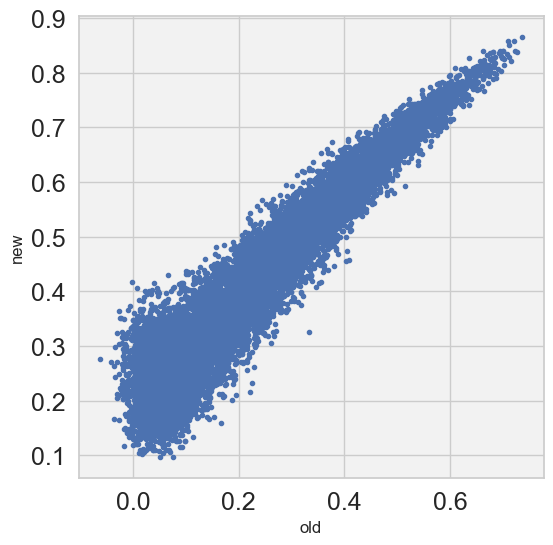

In [15]:
plt.figure(figsize=(6,6))
plt.plot(nsdcore_val_cc[1], subject_val_cc[1], marker='.', linestyle='None')
plt.xlabel('old')
plt.ylabel('new')

0.864958219635095
0.09669063394456323
0.42745993347590827


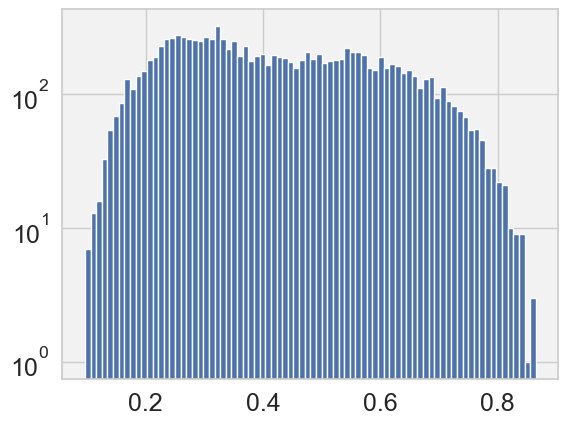

In [16]:

plt.hist(subject_val_cc[1], bins=80, log=True)
# plt.savefig("/export/raid1/home/kneel027/Second-Sight/charts/alexnet.png")
# plt.savefig("/export/raid1/home/kneel027/Second-Sight/charts/alexnet_average.png")
print(max(subject_val_cc[1]))
print(min(subject_val_cc[1]))
print(np.mean(subject_val_cc[1]))

# Save predictions

In [33]:
pred_data = {'pred': subject_image_pred,
            'val_cc': subject_val_cc,
            'voxel_roi': voxel_roi,
            'voxel_mask': voxel_mask,
            'voxel_index': voxel_idx,
            'brain_nii_shape': brain_nii_shape ,
           }

save_stuff( output_dir + 'nsd_prediction_all', flatten_dict(pred_data))

saved pred.1 in h5py file
saved pred.2 in h5py file
saved pred.3 in h5py file
saved pred.4 in h5py file
saved pred.5 in h5py file
saved pred.6 in h5py file
saved pred.7 in h5py file
saved pred.8 in h5py file
saved val_cc.1 in h5py file
saved val_cc.2 in h5py file
saved val_cc.5 in h5py file
saved val_cc.6 in h5py file
saved val_cc.3 in h5py file
saved val_cc.4 in h5py file
saved val_cc.7 in h5py file
saved val_cc.8 in h5py file
saved voxel_roi.1 in h5py file
saved voxel_roi.2 in h5py file
saved voxel_roi.3 in h5py file
saved voxel_roi.4 in h5py file
saved voxel_roi.5 in h5py file
saved voxel_roi.6 in h5py file
saved voxel_roi.7 in h5py file
saved voxel_roi.8 in h5py file
saved voxel_mask.1 in h5py file
saved voxel_mask.2 in h5py file
saved voxel_mask.3 in h5py file
saved voxel_mask.4 in h5py file
saved voxel_mask.5 in h5py file
saved voxel_mask.6 in h5py file
saved voxel_mask.7 in h5py file
saved voxel_mask.8 in h5py file
saved voxel_index.1 in h5py file
saved voxel_index.2 in h5py fil